# Прогнозирование временных рядов с использованием RNN

In [3]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Набор метеорологических данных

Во всех примерах данного ipynb используются временные последовательности данных о погоде, записанные на гидрометеорологической станции в Институте биогеохимии им. Макса Планка.

В этот набор данных включены замеры 14 различных метеорологических показателей (таких, как температура воздуха, атмосферное давление, влажность), выполняющиеся каждые 10 минут начиная с 2003 года. Для экономии времени и используемой памяти будут использоваться данные, охватывающие период с 2009 по 2016 год

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [5]:
df = pd.read_csv(csv_path)

Посмотрим, что у нас имеется.

In [6]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


В том, что период записи наблюдения составляет 10 минут, можно убедиться по вышеприведённой таблице. Таким образом, в течение одного часа будет 6 наблюдений. В свою очередь за сутки накапливается 144 (6x24) наблюдения.

Допустим, необходимо cпрогнозировать температуру, которая будет через 6 часов в будущем. Этот прогноз делается на основе имеющихся данных за определённый период: например, за 5 дней наблюдений. Следовательно, для обучения модели необходимо создать временной интервал, содержащий последние 720 (5x144) наблюдений

Приведенная ниже функция возвращает вышеописанные временные интервалы для обучения модели. Аргумент history_size — это размер последнего временного интервала, target_size – аргумент, определяющий насколько далеко в будущее модель должна научиться прогнозировать. Другими словами, target_size – это целевой вектор, который необходимо спрогнозировать.

In [7]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Изменение размера данных с (history_size,) на (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

В обеих частях ноутбука первые 300 000 строк данных будут использоваться для обучения модели, оставшиеся – для её валидации (проверки). В этом случае объём обучающих данных составляет примерно 2100 дней.

In [8]:
TRAIN_SPLIT = 300000

Для обеспечения воспроизводимости результатов устанавливается функция seed.

In [9]:
tf.random.set_seed(13)

## Часть 1. Прогнозирование на основе одномерного временного ряда

Для начала извлечем только температуру из набора данных.

In [10]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

И посмотрим, как эти данные изменяются во времени.

array([<AxesSubplot: xlabel='Date Time'>], dtype=object)

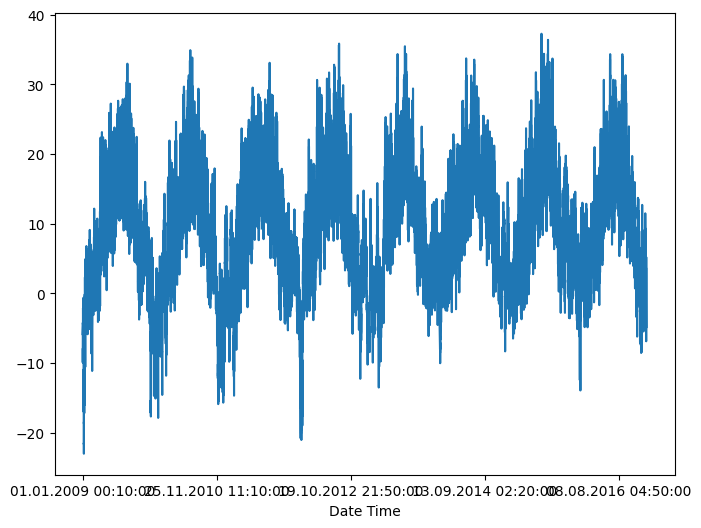

In [11]:
uni_data.plot(subplots=True)

In [12]:
uni_data = uni_data.values

Выполним стандартизацию данных.

In [13]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

Далее подготовим данные для модели с одномерным входом. На вход в модель будут подаваться последние 20 зарегистрированных наблюдений за температурой, и модель необходимо обучить прогнозировать температуру на следующем шаге по времени.

In [14]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

Результаты применения функции univariate_data.

In [15]:
print ('Временной интервал для наблюдений')
print (x_train_uni[0])
print ('\n Целевая температура для прогнозирования')
print (y_train_uni[0])

Временной интервал для наблюдений
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Целевая температура для прогнозирования
-2.1041848598100876


*Примечание*
*Подготовка данных для модели с одномерным входом схематично изображена на  рисунке ниже (для удобства на этом и последующих рисунках данные представлены в «сыром» виде, до стандартизации, а также без признака ‘Date time’ в качестве индекса)*  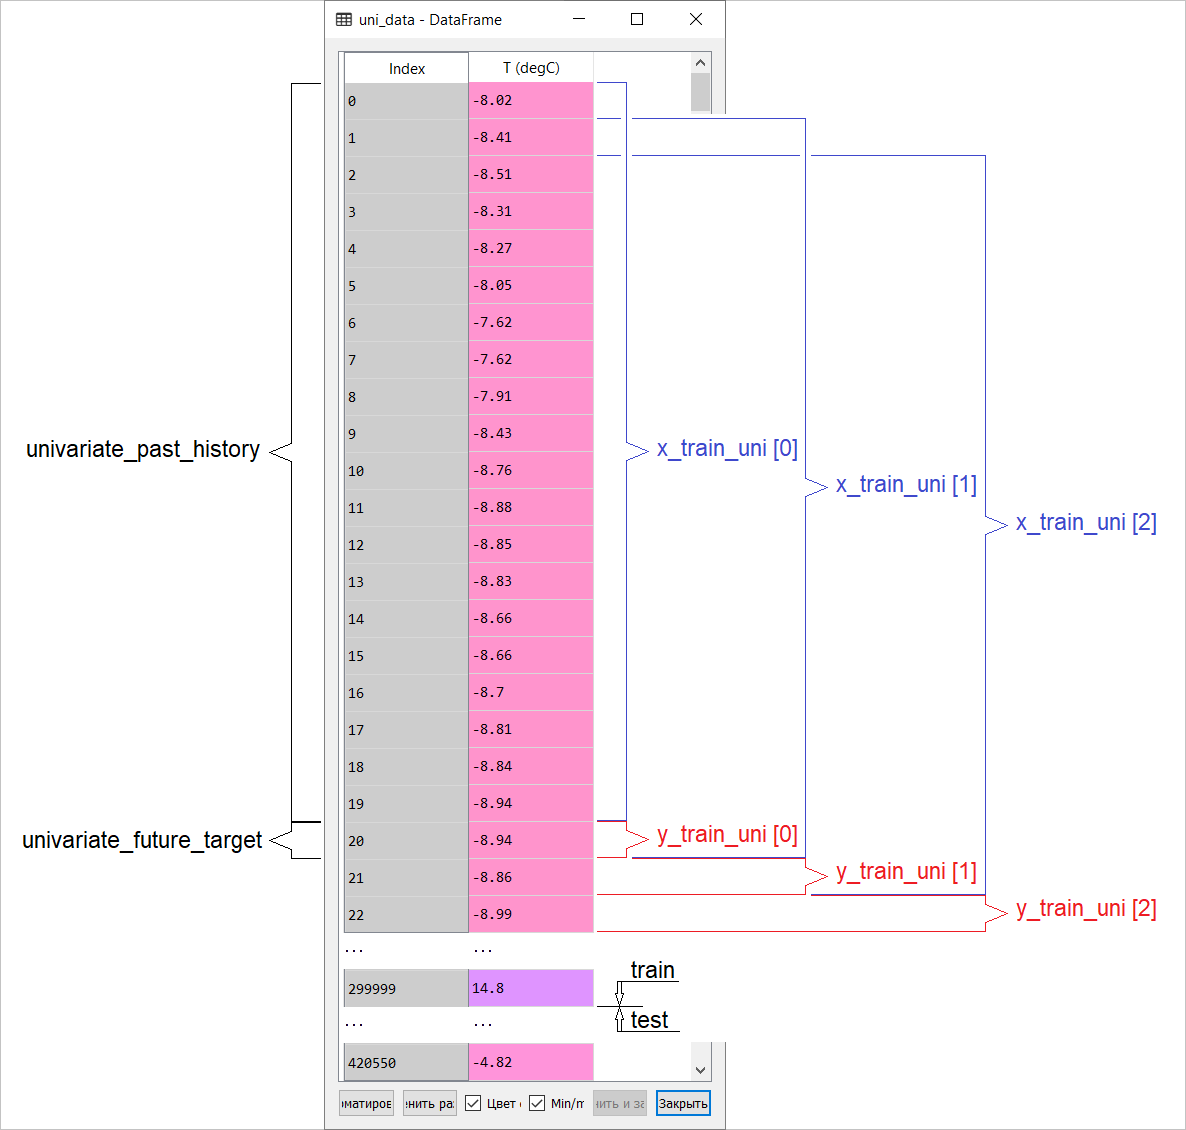

Теперь, когда данные соответствующим образом подготовлены, рассмотрим конкретный пример. Передаваемая в ИНС (искуственная нейронная сеть) информация на графике выделена синим цветом, а красным крестиком обозначено будущее значение, которое ИНС должна спрогнозировать.


In [16]:
def create_time_steps(length):
  return list(range(-length, 0))

In [17]:
def show_plot(plot_data, delta, title):
  labels = ['История', 'Истинное будущее значение', 'Прогноз модели']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Временной интервал')
  return plt

<module 'matplotlib.pyplot' from '/home/andor/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

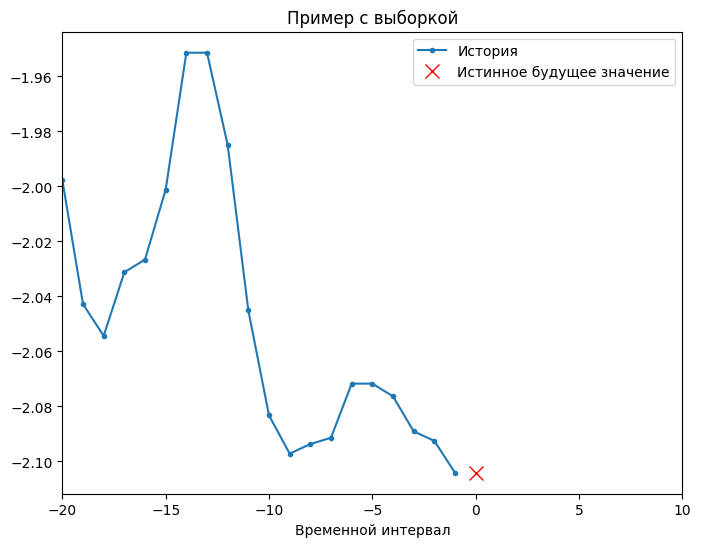

In [18]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Пример с выборкой')

#### Базовое решение (без привлечения машинного обучения)

Прежде чем приступить к обучению модели, установим простое базовое решение (baseline). Оно заключается в следующем: для заданного входного вектора метод базового решения «просматривает» всю историю и прогнозирует следующее значение как среднее из последних 20 наблюдений.

In [19]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/home/andor/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

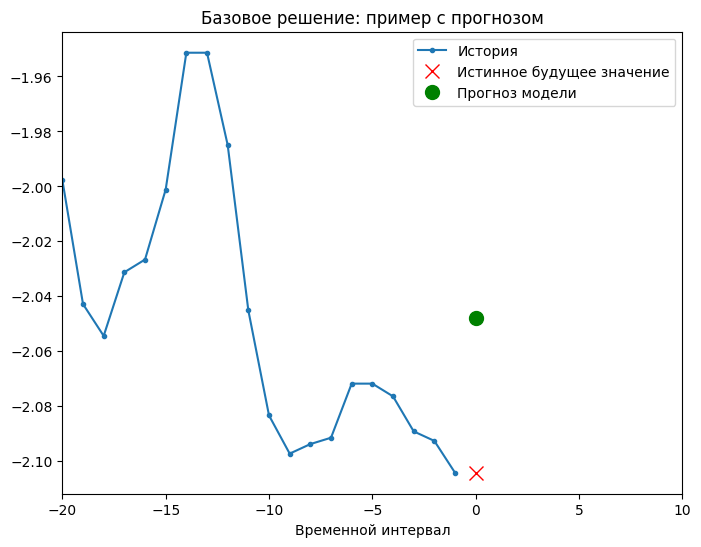

In [20]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Базовое решение: пример с прогнозом')

Посмотрим, сможем ли мы превзойти результат «усреднения», использую рекуррентную нейронную сеть.

#### Рекуррентная нейронная сеть


Рекуррентная нейронная сеть (РНС) — это тип ИНС, который хорошо подходит для решения задач, связанных с временными рядами. РНС шаг за шагом обрабатывает временную последовательность данных, перебирая её элементы и сохраняя внутреннее состояние, полученное при обработке предыдущих элементов.  В данном ноутбуке будет использоваться специализированный слой РНС, который называется «Долгая краткосрочная память» (англ. Long Short-Term Memory, LSTM).

Далее с помощью tf.data выполним перемешивание (shuffle), пакетирование (batch) и кэширование (cache) набора данных.

*Дополнение:*

*Подробнее про методы shuffle, batch и cache на странице [tensorflow](https://www.tensorflow.org/api_docs/python/tf/data/Dataset):*

In [21]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

2023-04-08 11:59:05.301352: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 47996800 exceeds 10% of free system memory.
2023-04-08 11:59:05.549682: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19284960 exceeds 10% of free system memory.


Следующая визуализация должна помочь понять, как выглядят данные после пакетной обработки.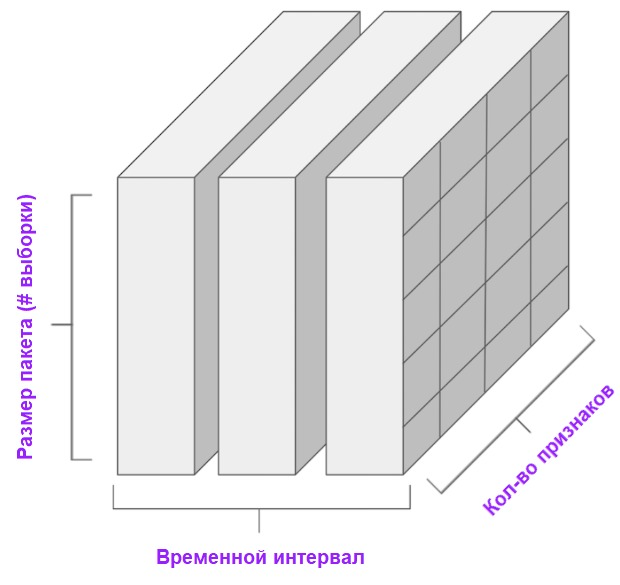

Видно, что LSTM требует определённой формы ввода данных, которые ему предоставляются.

In [22]:
simple_SimpleRNN_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_SimpleRNN_model.compile(optimizer='adam', loss='mae')

Проверим выход модели.

In [23]:
for x, y in val_univariate.take(1):
    print(simple_SimpleRNN_model.predict(x).shape)

2023-04-08 11:59:22.394415: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19284960 exceeds 10% of free system memory.


8/8 [==============================] - 0s 3ms/step
(256, 1)


*Дополнение:*

*В общем плане РНС работают с последовательностями (sequences). Это означает, что подаваемые на вход модели данные должны иметь следующую форму:*

*[наблюдения, временной интервал, кол-во признаков]*
*Форма обучающих данных для модели с одномерным входом имеет следующий вид:*

*print(x_train_uni.shape)*
*(299980, 20, 1)*

Далее займёмся обучением модели. Из-за большого размера набора данных и в целях экономии времени каждая эпоха будет проходить только 200 шагов (steps_per_epoch=200) вместо полных данных обучения, как это обычно делается.

In [24]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_SimpleRNN_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10


2023-04-08 11:59:29.420250: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 47996800 exceeds 10% of free system memory.


183/200 [==========================>...] - ETA: 0s - loss: 0.4293

2023-04-08 11:59:31.271095: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19284960 exceeds 10% of free system memory.


200/200 [==============================] - 2s 5ms/step - loss: 0.4164 - val_loss: 0.0942
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1113 - val_loss: 0.0370
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0506 - val_loss: 0.0255
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0496 - val_loss: 0.0231
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0274 - val_loss: 0.0208
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0294 - val_loss: 0.0201
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0180
Epoch 8/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0173
Epoch 9/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0168
Epoch 10/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0157


#### Прогнозирование с использованием простой модели LSTM

После выполнения подготовки простой LSTM-модели, выполним несколько прогнозов.

8/8 [==============================] - 0s 4ms/step


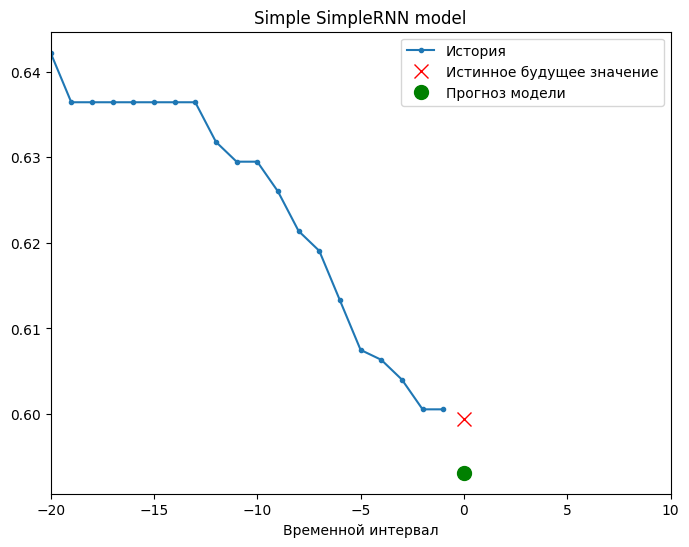

8/8 [==============================] - 0s 5ms/step


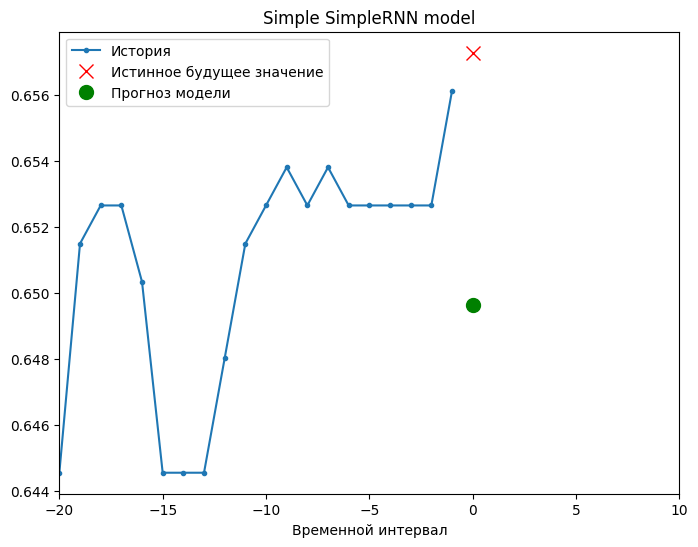

8/8 [==============================] - 0s 1ms/step


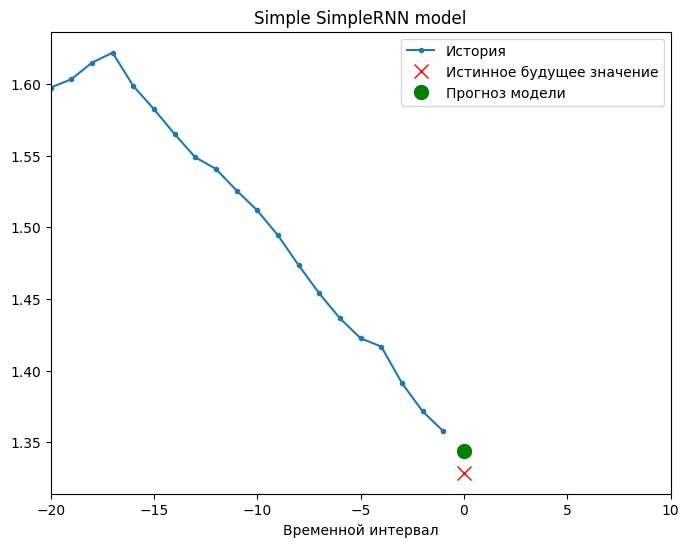

In [25]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_SimpleRNN_model.predict(x)[0]], 0, 'Simple SimpleRNN model')
  plot.show()

Выглядит лучше, чем базовый уровень.

Теперь, когда мы ознакомились с основами, давайте перейдем ко второй части, в которой описывается работа с многомерным временным рядом.

## Часть 2: Прогнозирование на основе многомерного временного ряда

Как было сказано, исходный набор данных содержит 14 различных метеорологических показателей. Для простоты и удобства во второй части рассматриваются только три из них — температура воздуха, атмосферное давление и плотность воздуха.

Чтобы использовать больше признаков, их названия нужно добавить в список feature_considered.

In [26]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [27]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Посмотрим, как эти показатели изменяются во времени.

array([<AxesSubplot: xlabel='Date Time'>,
       <AxesSubplot: xlabel='Date Time'>,
       <AxesSubplot: xlabel='Date Time'>], dtype=object)

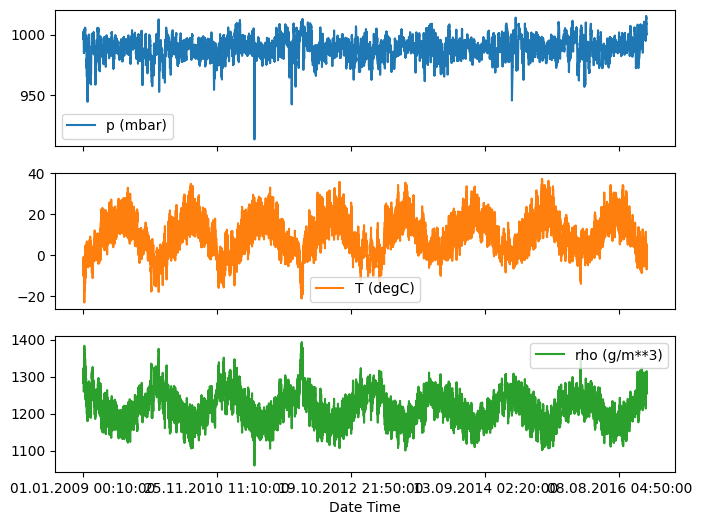

In [28]:
features.plot(subplots=True)

Как и ранее, первым шагом будет выполнение стандартизации набора данных с вычислением среднего значения и стандартного отклонения обучающих данных.

In [29]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

Дополнение:

Далее в ноутбуке будет рассказано о точечном и интервальном прогнозировании.
Суть в следующем. Если вам нужно, чтобы модель прогнозировала одно значение в будущем (например, значение температуры через 12 часов) (one-step/single step model), то и обучить модель вы должны таким образом, чтобы она прогнозировала только одно значение в будущем. Если задача состоит в прогнозировании интервала значений в будущем (например, ежечасные значения температуры в течение следующих 12 часов) (multi-step model), то и модель должна быть обучена прогнозировать интервал значений в будущем.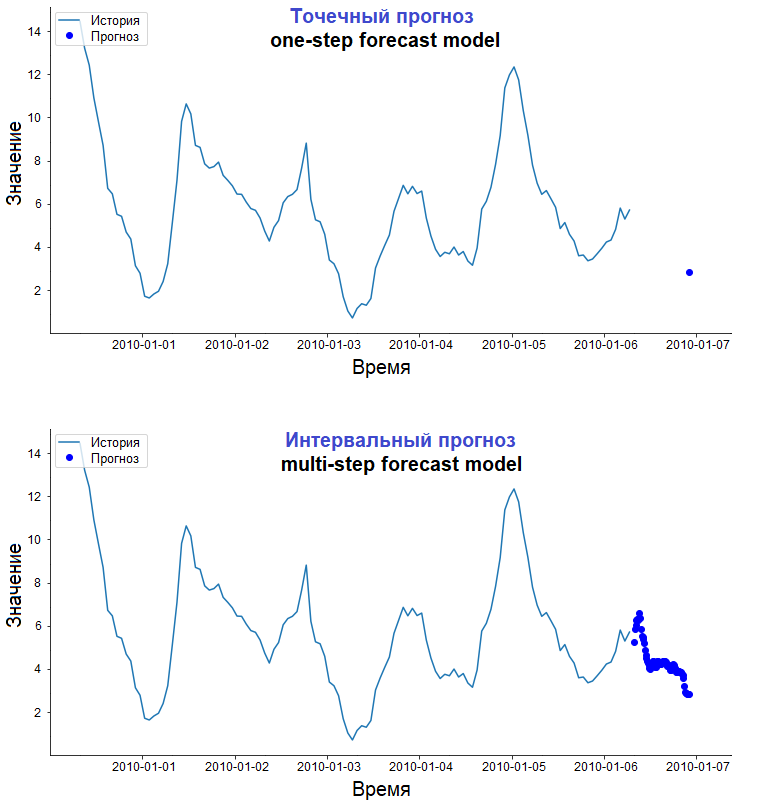

#### Точечное прогнозирование

В данном случае модель обучается прогнозированию одного значения в будущем на основе некой имеющейся истории.
Приведенная ниже функция выполняет ту же задачу организации временных интервалов лишь с тем отличием, что здесь она отбирает последние наблюдения на основе заданного размера шага.

In [30]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

В данном руководстве ИНС оперирует данными за последние пять (5) дней, то есть 720 наблюдениями (6х24х5). Допустим, что отбор данных проводится не каждые 10 минут, а каждый час: в течение 60 минут резкие изменения не ожидаются. Следовательно, историю последних пяти дней составляют 120 наблюдений (720/6). Для модели, выполняющей точечное прогнозирование, целью является значение температуры через 12 часов в будущем. В этом случае целевой вектор будет составлять температура после 72 (12х6) наблюдений

In [31]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Проверим временной интервал.

In [32]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [33]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [34]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.SimpleRNN(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Проверим нашу выборку и выведем кривые потерь на этапах обучения и проверки.

In [35]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

8/8 [==============================] - 8s 24ms/step
(256, 1)


In [36]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 9s 29ms/step - loss: 0.3286 - val_loss: 0.2903
Epoch 2/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2893 - val_loss: 0.2393
Epoch 3/10
200/200 [==============================] - 6s 32ms/step - loss: 0.2920 - val_loss: 0.2472
Epoch 4/10
200/200 [==============================] - 5s 25ms/step - loss: 0.2805 - val_loss: 0.2365
Epoch 5/10
200/200 [==============================] - 5s 23ms/step - loss: 0.2474 - val_loss: 0.2306
Epoch 6/10
200/200 [==============================] - 7s 34ms/step - loss: 0.2605 - val_loss: 0.2823
Epoch 7/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2590 - val_loss: 0.2600
Epoch 8/10
200/200 [==============================] - 5s 24ms/step - loss: 0.2651 - val_loss: 0.2735
Epoch 9/10
200/200 [==============================] - 5s 23ms/step - loss: 0.2669 - val_loss: 0.2485
Epoch 10/10
200/200 [==============================] - 5s 23ms/step - loss: 0.2548 - val_lo

In [37]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Потери на этапе обучения')
  plt.plot(epochs, val_loss, 'r', label='Потери на этапе проверки')
  plt.title(title)
  plt.legend()

  plt.show()

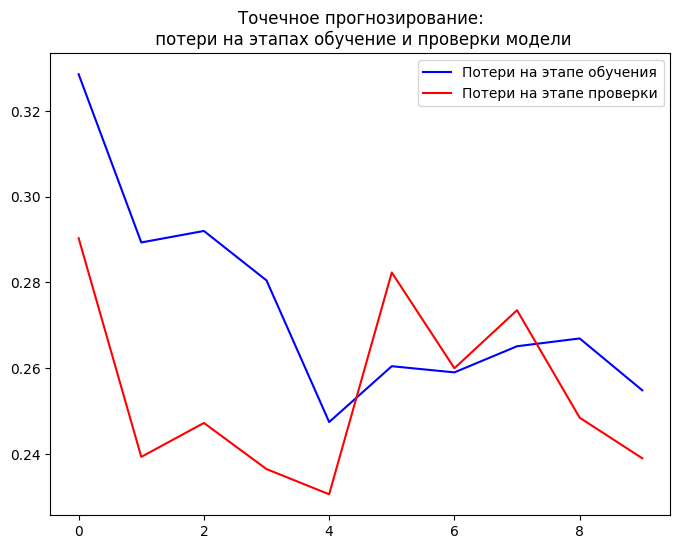

In [38]:
plot_train_history(single_step_history,
                   'Точечное прогнозирование:\n потери на этапах обучение и проверки модели')

*Дополнение*:

*Подготовка данных для модели с многомерным входом, выполняющей точечное прогнозирование, схематично изображена на следующем рисунке. Для удобства и более наглядного представления подготовки данных аргумент STEP равен 1. Обратите внимание, что в приводимых функциях-генераторах аргумент STEP предназначен только для формирования истории, а не для целевого вектора.*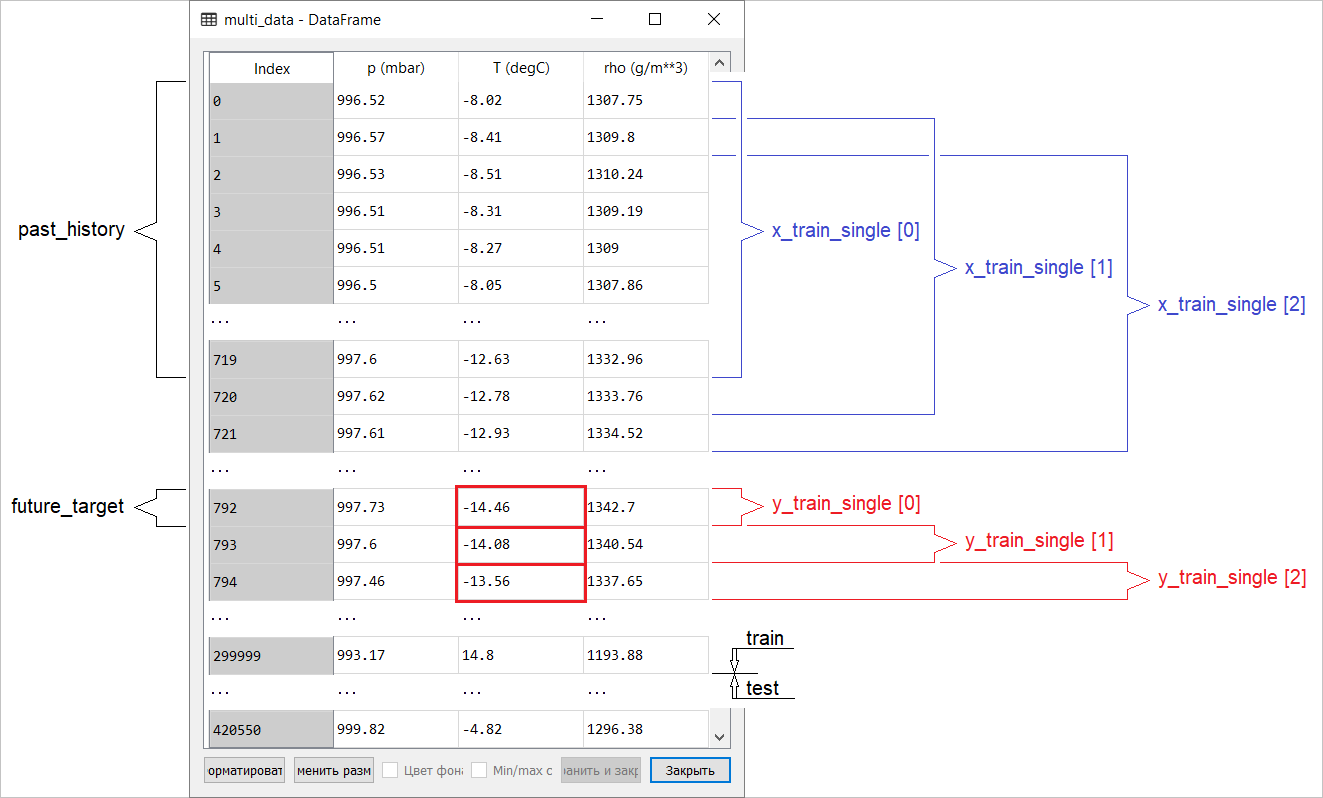

*В этом случае x_train_single имеет форму (299280, 720, 3).
При STEP=6, форма примет следующий вид: (299280, 120, 3) и скорость выполнения функции увеличиться в разы.*

#### Выполнение точечного прогноза

Теперь, когда модель обучена, выполним несколько пробных прогнозов. На вход модели подаётся история наблюдений 3-х признаков за последние пять дней, отобранных каждый час (временной интервал = 120). Так как наша цель заключается в прогнозе только температуры, то синим цветом на графике отображены прошлые значения температуры (история). Прогноз выполнен на полдня в будущее (отсюда и разрыв между историей и спрогнозированным значением).

8/8 [==============================] - 0s 8ms/step


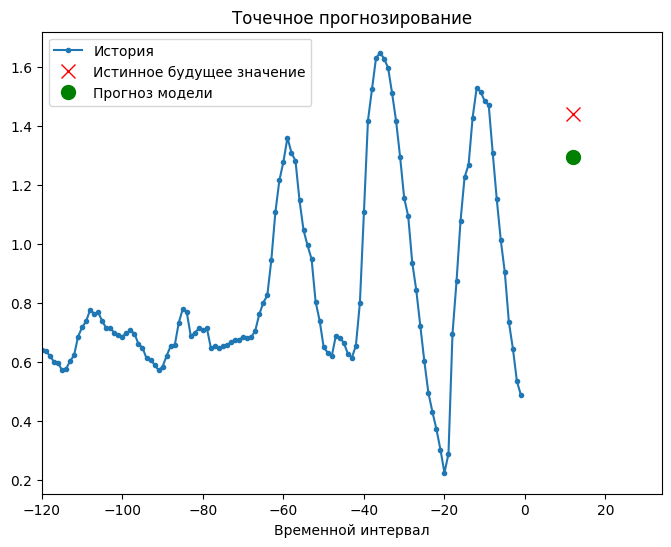

8/8 [==============================] - 0s 7ms/step


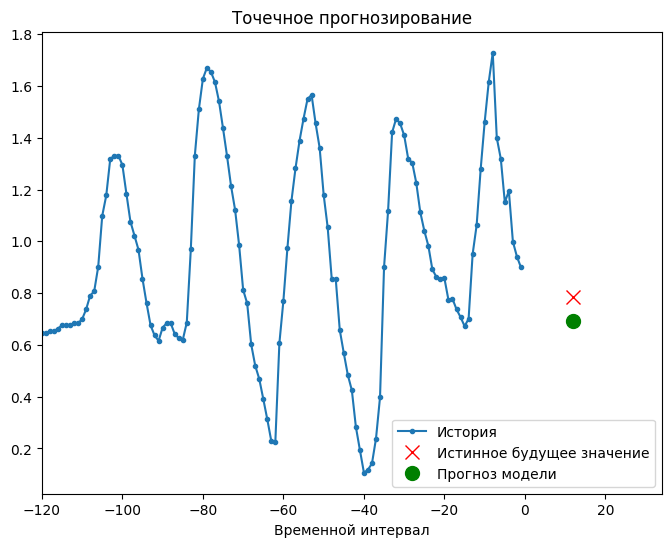

8/8 [==============================] - 0s 6ms/step


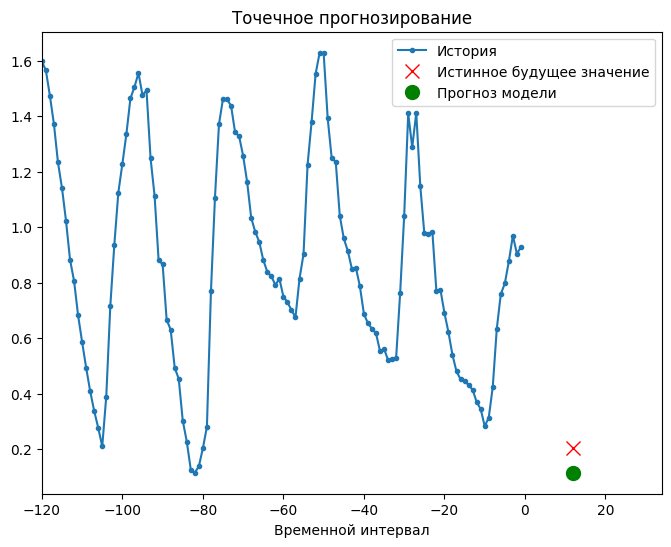

In [39]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Точечное прогнозирование')
  plot.show()

#### Интервальное прогнозирование

В этом случае на основе некой имеющейся истории модель обучается прогнозированию интервала будущих значений. Таким образом, в отличие модели, прогнозирующей только на одно значение в будущее, данная модель прогнозирует последовательность значений в будущем.

Допустим, как и в случае с моделью, выполняющей точечное прогнозирование, для модели, выполняющей интервальное прогнозирование, обучающими данными являются почасовые замеры последних пяти дней (720/6). Однако в данном случае модель необходимо обучить прогнозировать температуру на следующие 12 часов. Поскольку наблюдения регистрируются каждые 10 минут, выход (output) модели должен состоять из 72 прогнозов. Для выполнения этой задачи необходимо подготовить набор данных заново, но с другим целевым интервалом.

In [38]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Проверим выборку

In [39]:
print ('Временной интервал для наблюдений : {}'.format(x_train_multi[0].shape))
print ('\n Целевая температура для прогнозирования : {}'.format(y_train_multi[0].shape))

Временной интервал для наблюдений : (120, 3)

 Целевая температура для прогнозирования : (72,)


In [40]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

*Дополнение: отличие в формировании целевого вектора для «интервальной модели» от «точечной модели» видно на следующем рисунке.*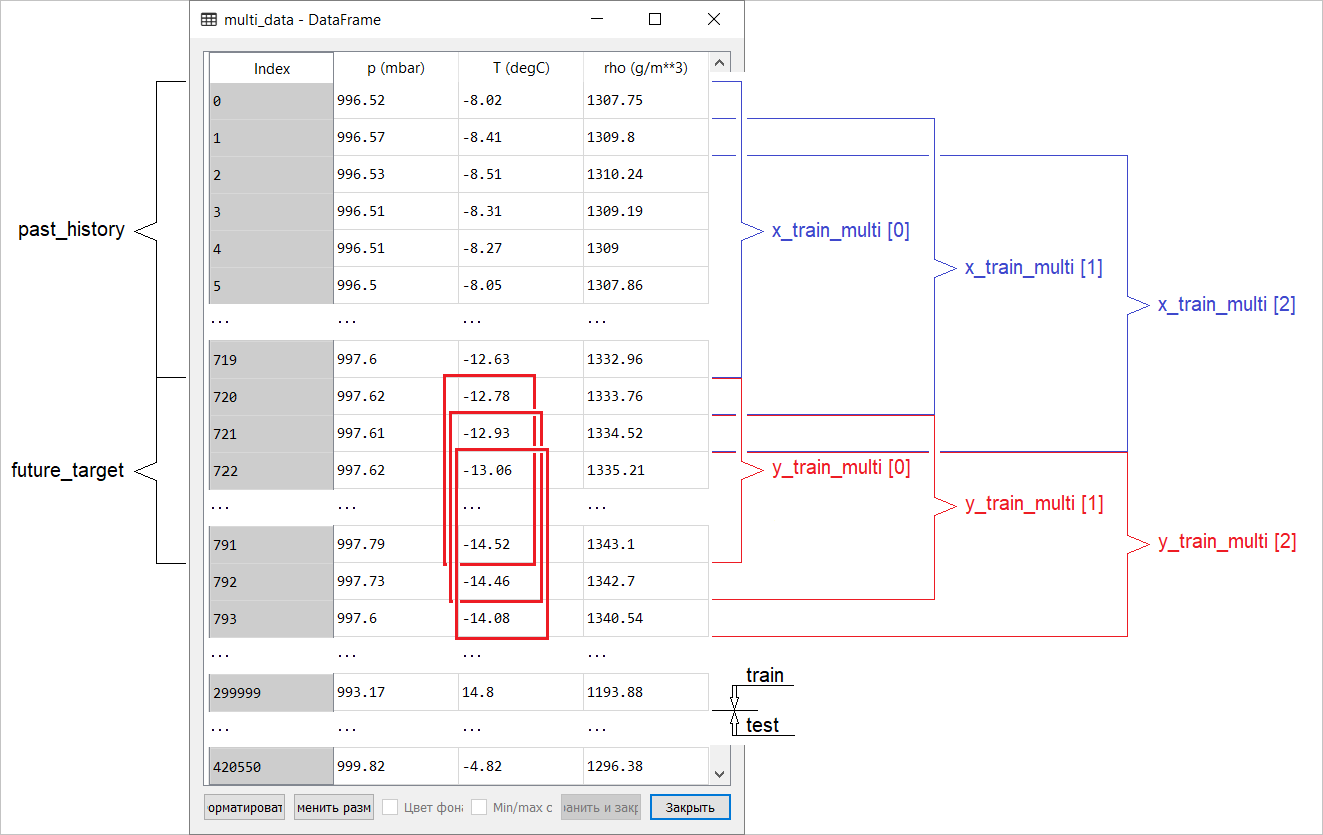

Подготовим визуализацию

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='История')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='Истинное будущее значение')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Прогноз модели')
  plt.legend(loc='upper left')
  plt.show()

На этом и последующих аналогичных графиках история и будущие данные ежечасные

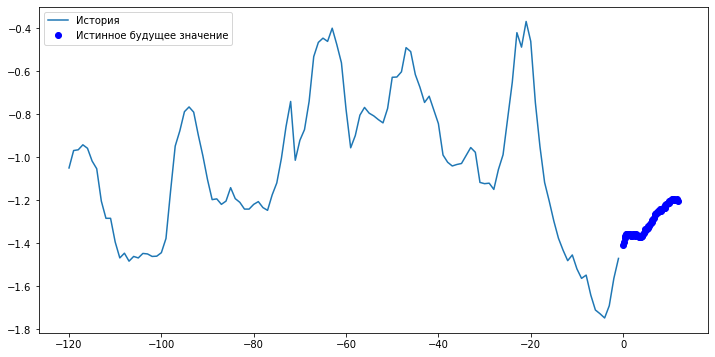

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Так как эта задача немного сложнее, чем предыдущая, то модель будет состоять из двух слоёв LSTM. Наконец, поскольку выполняется 72 прогноза, выход слой насчитывает 72 нейрона.

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.SimpleRNN(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.SimpleRNN(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Проверим нашу выборку и выведем кривые потерь на этапах обучения и проверки

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 [==============================] - 1s 22ms/step
(256, 72)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 46s 211ms/step - loss: 0.4706 - val_loss: 0.2968
Epoch 2/10
200/200 [==============================] - 44s 219ms/step - loss: 0.3161 - val_loss: 0.2608
Epoch 3/10
200/200 [==============================] - 40s 201ms/step - loss: 0.2747 - val_loss: 0.2292
Epoch 4/10
200/200 [==============================] - 49s 243ms/step - loss: 0.2367 - val_loss: 0.2054
Epoch 5/10
200/200 [==============================] - 46s 231ms/step - loss: 0.1989 - val_loss: 0.1980
Epoch 6/10
200/200 [==============================] - 40s 200ms/step - loss: 0.2085 - val_loss: 0.2233
Epoch 7/10
200/200 [==============================] - 47s 233ms/step - loss: 0.2021 - val_loss: 0.2097
Epoch 8/10
200/200 [==============================] - 43s 212ms/step - loss: 0.1997 - val_loss: 0.1964
Epoch 9/10
200/200 [==============================] - 39s 196ms/step - loss: 0.2006 - val_loss: 0.2012
Epoch 10/10
200/200 [==============================] - 41s 205ms/step - l

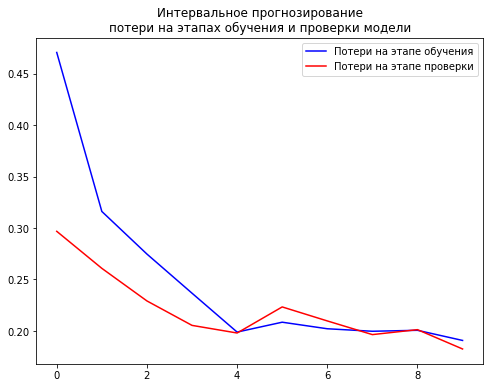

In [ ]:
plot_train_history(multi_step_history, 'Интервальное прогнозирование\nпотери на этапах обучения и проверки модели')

#### Выполнение интервального прогноза

Итак, давайте выясним, насколько успешно обученная ИНС справляется с прогнозами будущих значений температуры.

8/8 [==============================] - 0s 22ms/step


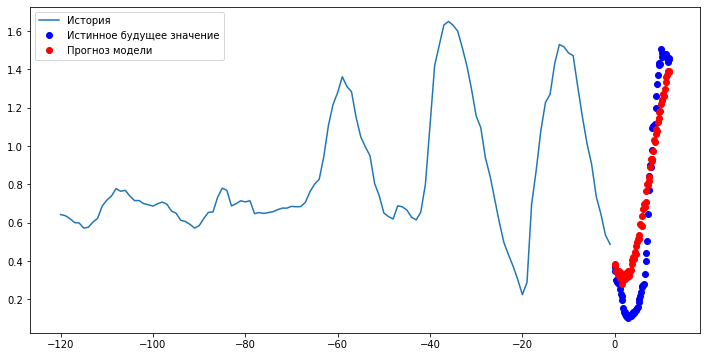

8/8 [==============================] - 0s 26ms/step


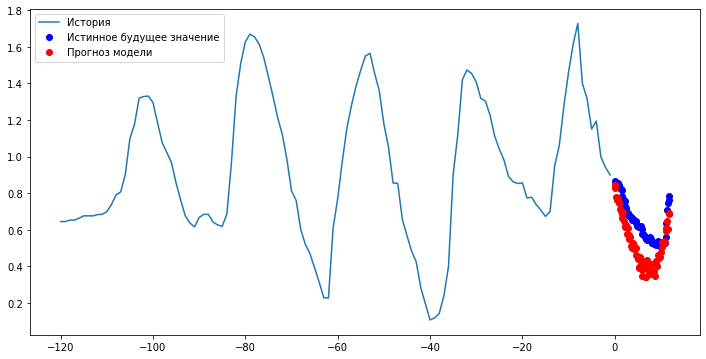

8/8 [==============================] - 0s 24ms/step


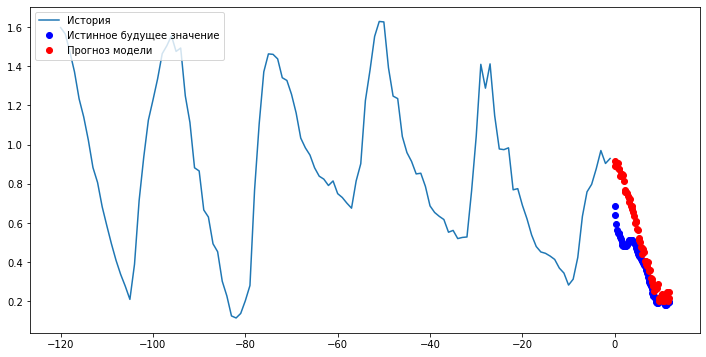

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

# Задание

1. Измените LSTM на SimpleRNN и посмотрите как измениться точность обучения и прогноза.
2. Создайте модель машинного обучения для прогнозирования будущей стоимости акций, торгуемых на фондовой бирже. Подходящий набор данных можно найти на Kaggle. Можно найти и другой датасет, чтобы построить прогноз какого-то значения, не обязательно, акции. При этому обратите внимание, что этот ноутбук должне содержать Последовательность данных (временной ряд), а не просто набор значений. 